# A introductorial tutorial for time series
In this tutorial, we will cover the basics of working with time series data, including
1. Reading and displaying data 
2. Stationarity and how to check it
3. Transform time series data using log and differencing method
4. Decompose time series data to trend and seasonality
5. Autocorrelation function (ACF) and Partial Autocorrelation function (PACF)
6. Time series model: AR, MV, ARMA and ARIM model
7. Model selection
8. Forecast

The tutorial uses and builds on the following resources: [this post](https://builtin.com/data-science/time-series-python), [this post](https://www.kaggle.com/code/sunaysawant/air-passengers-time-series-arima/notebook), [this post](https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7), [this article](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), [Chapter 3 of this book](https://link.springer.com/book/10.1007/978-3-319-52452-8). We demonstrate these concepts and associated analysis using a running example with airline passenger data (found [here](https://www.kaggle.com/datasets/chirag19/air-passengers)). 

## Import data
Import the libraries and read airline passenger data (found [here](https://www.kaggle.com/datasets/chirag19/air-passengers)) into a data frame. This is a simple univariate time series: you are welcome to extend the analysis we do here to more complicated time series (e.g. multivariate). 

In [2]:
import pandas as pd
import numpy as np


df = pd.read_csv("AirPassengers.csv")

# Now we want to convert the month column into a datetime object
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

# Use Month column as index column
df.index = df['Month']
del df['Month']
print(df.head())

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


Next, let’s generate a time series plot using seaborn.

Text(0, 0.5, 'Number of Passengers')

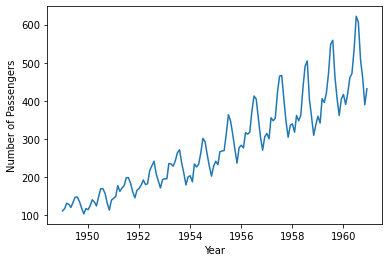

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

#sns.lineplot(data=df)
plt.plot(df)
plt.xlabel('Year')
plt.ylabel('Number of Passengers')

## Stationarity
Stationarity of a time series means that the manner in which time series data changes is constant, without any trends or seasonal patterns. It is an important assumtion to check before we fit data to a time series model. For instance, we know that, thanks to the [Wold decomposition theorem](https://en.wikipedia.org/wiki/Wold%27s_theorem), any stationary data can be approximated by the ARMA model (covered later). So we want to make sure our data is more or less stationary before fitting it to such models. To check stationary, we can visual the data by plotting its rolling mean and standard deviation (std), or utilize statistical test like the Dickey Fuller test. To start, let's calculate a 7-month rolling mean:

In [4]:
rolling_mean = df.rolling(7).mean()
rolling_std = df.rolling(7).std()

Next, let’s overlay our time series with the seven-month rolling mean and seven-month rolling standard deviation:

Text(0, 0.5, 'Number of Passengers')

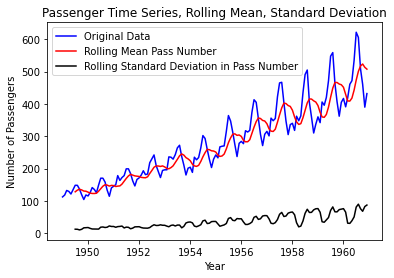

In [5]:
plt.plot(df, color="blue",label="Original Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean Pass Number")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Pass Number")
plt.title("Passenger Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")
plt.xlabel('Year')
plt.ylabel('Number of Passengers')

Next, let’s import the augmented Dickey-Fuller test from the statsmodels package. Let’s pass our data frame into the adfuller method. Here, we specify the autolag parameter as “AIC,” which means that the lag is chosen to minimize the information criterion:

In [6]:
from statsmodels.tsa.stattools import adfuller

adft = adfuller(df,autolag='AIC')
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0    0.815369              Test Statistics
1    0.991880                      p-value
2   13.000000             No. of lags used
3  130.000000  Number of observations used
4   -3.481682          critical value (1%)
5   -2.884042          critical value (5%)
6   -2.578770         critical value (10%)


From above plot, we can see that Rolling Mean itself has a trend component even though Rolling Standard Deviation is fairly constant with time. For time series to be stationary, we need to ensure that both Rolling Mean and Rolling Standard Deviation remain fairly constant with respect to time.


For a time series to be stationary, the augmented Dickey-Fuller test should satisfy: p-value should be low (according to the null hypothesis); The critical values at 1%,5%,10% confidence intervals should be as close as possible to the test statistics. From the above test result, we can see that p-value(near to 1.0) is very large. Also critical values are no where close to the test statistics. Hence, we can safely say that our time series at the moment is NOT STATIONARY. For later convenience, we wrote a function to test stationarity:

In [7]:
def test_stationarity(df):
    
    # Plot rolling mean and std
    rolling_mean = df.rolling(7).mean()
    rolling_std = df.rolling(7).std()
    plt.plot(df, color="blue",label="Original Data")
    plt.plot(rolling_mean, color="red", label="Rolling Mean Pass Number")
    plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Pass Number")
    plt.title("Passenger Time Series, Rolling Mean, Standard Deviation")
    plt.legend(loc="best")
    
    # Perform augmented Dickey-Fuller test
    adft = adfuller(df,autolag='AIC')
    output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    print(output_df)
    

## Transform the data into stationary data
Since our data is not stationary, we want to transform it into a stationary time series before we model it. The simplest way is to take log to lower the rate at which rolling mean increases and looking at the difference between value at each time point and value at the previous time point. This latter step is called a time-shift transformation or differencing: this step is the difference between ARMA and ARIMA model that we will cover below. 

       Values                       Metric
0   -2.717131              Test Statistics
1    0.071121                      p-value
2   14.000000             No. of lags used
3  128.000000  Number of observations used
4   -3.482501          critical value (1%)
5   -2.884398          critical value (5%)
6   -2.578960         critical value (10%)


Text(0, 0.5, 'Differenced Log-transform of Number of Passengers')

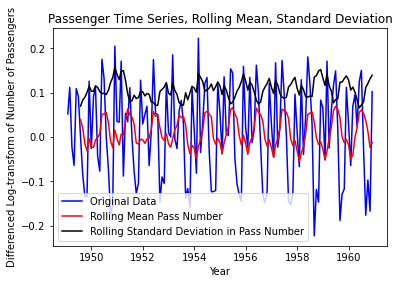

In [8]:
df_log = np.log(df)
df_logdff=df_log -df_log.shift()
df_logdff.dropna(inplace=True)
test_stationarity(df_logdff)
plt.xlabel('Year')
plt.ylabel('Differenced Log-transform of Number of Passengers')

The result looks much better! In some cases, one differencing like we did here is not enough, in which case we can apply differencing again. That is called a second-order difference. One can do higher-order differencing analogously. There are many other data transformation techniques, such as [power transform](https://en.wikipedia.org/wiki/Power_transform), [seasonal differencing](https://people.duke.edu/~rnau/411sdif.htm). 

## Decomposition: trend, seasonality and residue
Trend decomposition is another useful way to visualize the trends in time series data. To proceed, let’s import seasonal_decompose from the statsmodels package and pass our data frame into the seasonal_decompose method and plot the result:

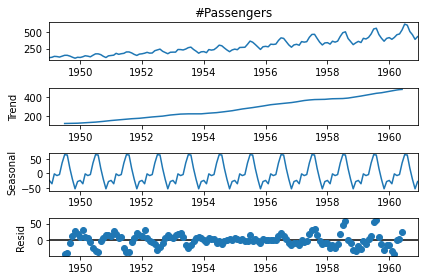

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['#Passengers'],model='additive', period=12)
decompose.plot()
plt.show()

Here, we observe that the original time series is decomposed a clear upward trend and a seasonal pattern with period of about 12 months. 

## Autocorrelation: ACF & PACF
### Autocorrelation function (ACF)
Auto-correlation is a measure of how correlated time series data is at a given point in time with past values. For example, if our data has strong autocorrelation, we can assume that high passenger numbers today suggest a strong likelihood that they will be high tomorrow as well. 

Autocorrelation function (ACF) simply shows us the correlation at different lags. We can use ACF to determine the optimal number of terms in the Moving Average (MA) model which we will cover later. We can plot ACF for log difference series as follows.

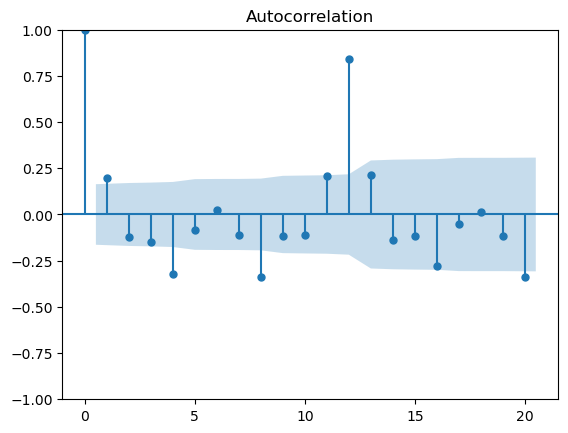

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_logdff, lags=20);

What you can see here are bars and a horizontal cone. This cone pictures the confidence level (by default set to 95%). In other words, if the point is outside the cone (on white) you may say that with 95% probability is has a certain impact on values. If the bar is inside the cone (on blue) you may ignore this particular lag as most likely it is not relevant. 

### Partial autocorrelation function (PACF)
The partial autocorrelation function (PACF) gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. It contrasts with the ACF, which does not control for other lags. We can use PACF to determine the optimal number of terms to use in the AutoRegressive (AR) model that we will later cover. 

C:\Users\Patrick\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


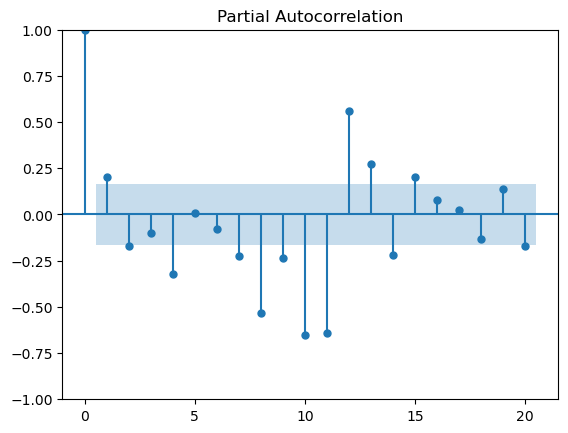

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_logdff, lags=20);

## Time series models
Before we continue, let us cover some fundamental times series models. Once we fit our data to one of these models, we can use the fitted model for forecasting. 


### AutoRegressive Model (AR)
Autoregressive models operate under the premise that past values have an effect on current values. As long as the assumption holds, we can build a linear regression model that attempts to predict value of a dependent variable today, given the values it had on previous days:
$$
X_{t}=c+\sum_{i=1}^{p} \varphi_{i} X_{t-i}+\varepsilon_{t}
$$
where $(\varphi_{i})_{i\ge 1}$ are model parameters, $c$ is a constant, and the random variable $\epsilon_t$ is white noise. 

Let us fit an AR model. Looking back at our PACF plot, $p=4$ seems to be a good choice (more on this later). Note that the order for ARIMA model below is set to be $(p=4,d=0,q=0)$: here p is the number of autoagressive terms, d is the differencing order, q is number of moving-average terms. What we are doing below is to fit AR model for the log-transoformed data after differecing (since df_logdff is already differenced once so d=0). We also computed the residual sum of squares (RSS) comparing fitted (in red) and original series (in blue). 

Plotting AR model


Text(0, 0.5, 'Differenced Log-transform of Number of Passengers')

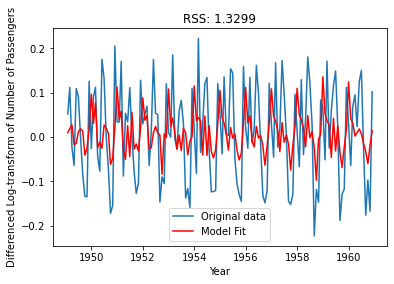

In [10]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

model1 = ARIMA(df_logdff, order=(4,0,0))
results_AR = model1.fit()
plt.plot(df_logdff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - df_logdff['#Passengers'])**2))
plt.legend(['Original data','Model Fit'])
print('Plotting AR model')
plt.xlabel('Year')
plt.ylabel('Differenced Log-transform of Number of Passengers')

### Moving Average Model (MA)
Assumes that the current value is series mean plus linear combination of errors from previous values. The formula can be expressed as:
$$
X_{t}=\mu+\varepsilon_{t}+\sum_{i=1}^{q} \theta_{i} \varepsilon_{t-i}
$$
where the $\theta_{1}, \ldots, \theta_{q}$ are the parameters of the model, $\mu$ is the expectation of $X_{t}$, and the $\varepsilon_{t}, \varepsilon_{t-1}, \ldots$ are again, white noise error terms.

Let us fit an MA model for our data. Our ACF plot above suggests 4 MA terms:

Plotting MA model


Text(0, 0.5, 'Differenced Log-transform of Number of Passengers')

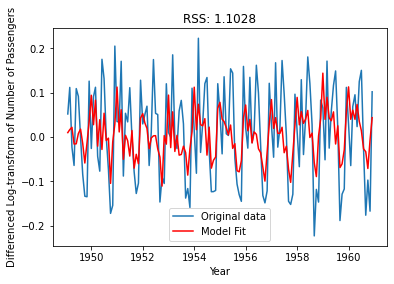

In [11]:
warnings.filterwarnings('ignore')

model2 = ARIMA(df_logdff, order=(0,0,4))
results_MA = model2.fit()
plt.plot(df_logdff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - df_logdff['#Passengers'])**2))
plt.legend(['Original data','Model Fit'])
print('Plotting MA model')
plt.xlabel('Year')
plt.ylabel('Differenced Log-transform of Number of Passengers')

### Autoregressive–moving-average (ARMA) model and Autoregressive–integrated-moving-average (ARIMA) model 
The notation ARMA $(p, q)$ refers to the model with $p$ autoregressive terms and $q$ moving-average terms. This model contains the AR $(p)$ and MA( $q)$ models,
$$
X_{t}=c+\varepsilon_{t}+\sum_{i=1}^{p} \varphi_{i} X_{t-i}+\sum_{i=1}^{q} \theta_{i} \varepsilon_{t-i} .
$$
Generally, we only apply ARMA model to stationary time series. For non-stationary time series data, we would apply a differencing step and apply ARMA model to the differenced series. The fitted model is then integrated to recover a model for the before-differencing series. The ARIMA model is essentially ARMA model but applied to the differenced time series with the integration step at the end. 

Since we already applied the differencing step for our data, we will only need to apply ARMA to the differenced series. The choice of $p,q=4$ is by observing the ACF and PACF plots. 

Plotting ARIMA model


Text(0, 0.5, 'Differenced Log-transform of Number of Passengers')

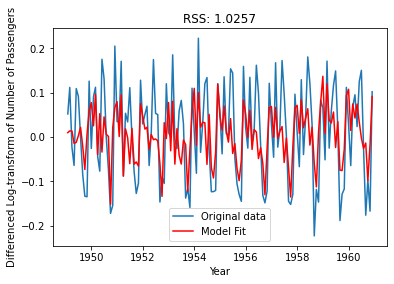

In [12]:
warnings.filterwarnings('ignore')

model3 = ARIMA(df_logdff, order=(4,0,4))
results_ARMA = model3.fit()
plt.plot(df_logdff)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARMA.fittedvalues - df_logdff['#Passengers'])**2))
plt.legend(['Original data','Model Fit'])
print('Plotting ARIMA model')
plt.xlabel('Year')
plt.ylabel('Differenced Log-transform of Number of Passengers')

## Model Selection
In the previous section, we picked the $p,q=4$ for our ARIMA model by "eye-balling" the ACF and PACF plots.  But this is not a very rigorous approach and sometimes the choice of $p,q$ can be ambiguous. In our case, from the plot alone, one seems to be justified to pick $p,q$ to be other values as well. For example, there are some spikes in ACF and PACF plot at around lag 8-14. Let us try setting $p,q=8$ and $p,q=20$:

Plotting ARIMA model,p=q=6


Text(0, 0.5, 'Differenced Log-transform of Number of Passengers')

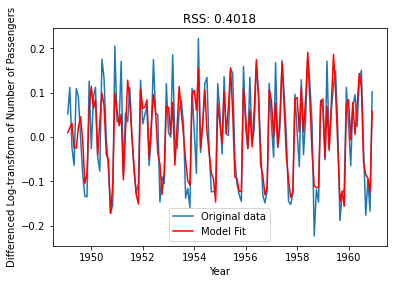

In [13]:
warnings.filterwarnings('ignore')

model4 = ARIMA(df_logdff, order=(8,0,8))
results_ARMApq8 = model4.fit()
plt.plot(df_logdff)
plt.plot(results_ARMApq8.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARMApq8.fittedvalues - df_logdff['#Passengers'])**2))
plt.legend(['Original data','Model Fit'])
print('Plotting ARIMA model,p=q=6')
plt.xlabel('Year')
plt.ylabel('Differenced Log-transform of Number of Passengers')

Plotting ARIMA model,p=q=20


Text(0, 0.5, 'Differenced Log-transform of Number of Passengers')

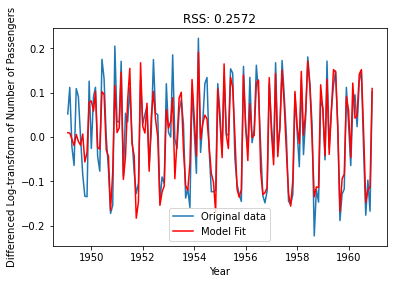

In [14]:
warnings.filterwarnings('ignore')

model5 = ARIMA(df_logdff, order=(20,0,20))
results_ARMApq20 = model5.fit()
plt.plot(df_logdff)
plt.plot(results_ARMApq20.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARMApq20.fittedvalues - df_logdff['#Passengers'])**2))
plt.legend(['Original data','Model Fit'])
print('Plotting ARIMA model,p=q=20')
plt.xlabel('Year')
plt.ylabel('Differenced Log-transform of Number of Passengers')

Looks like we are doing much better than before! But should we go for $p,q=20$ instead? Note that as we increase $p,q$, we will generally observe increased goodness of fit to the data as we are using more complex, or larger models (more parameters to fit). On the other hand, we run the risk of overfitting the data in which case the model will likely give unsatisfying prediction performance. 

The Akaike Information Criteria (AIC) and Bayesian Information Criteria (BIC) are two metrics that we can use to compare different selection of $p,q$ values taking into account of this trade-off: simply put, they reward goodness of fit but punish the use of more complex models. AIC and BIC are defined as follows:
$$
\mathrm{AIC}=-2 \log (L)+2(p+q+k)
$$
where $L$ is the likelihood of the data, $p$ is the order of the autoregressive part and $q$ is the order of the moving average part. The $k$ represents the intercept of the ARIMA model.

The Bayesian Information Criterion (BIC) can be written as
$$
\mathrm{BIC}=\mathrm{AIC}+((\log T)-2)(p+q+k).
$$
where $T$ is the length of the time series. A few word on their difference: in theory, the AIC is supposed to approximate models towards the reality of the situation, the BIC attempts to find the perfect fit. The pratical effect is that BIC punishes model complexity more severely. 

When $T$ is small, AIC is prone to select models that have too many parameters (i.e. overfitting). The corrected AIC (AICc) is developed to correct this problem:The corrected AIC for ARIMA models can be written as
$$
\mathrm{AICc}=\mathrm{AIC}+\frac{2(p+q+k)(p+q+k+1)}{T-p-q-k-1} .
$$
We want to pick model that has the smallest AIC, AICc, BIC values. It seems from the data below that $p=q=8$ would be the best model choice among the three with $p=q=20$ overfitting. You are welcome to compute AIC, AICc and BIC for other model choices. 

In [15]:
print('AIC: p=q=4',results_ARMA.aic)
print('AIC: p=q=8',results_ARMApq8.aic)
print('AIC: p=q=20',results_ARMApq20.aic,'\n')

print('AICc: p=q=4',results_ARMA.aicc)
print('AICc: p=q=8',results_ARMApq8.aicc)
print('AICc: p=q=20',results_ARMApq20.aicc,'\n')

print('BIC: p=q=4',results_ARMA.bic)
print('BIC: p=q=8',results_ARMApq8.bic)
print('BIC: p=q=20',results_ARMApq20.bic,'\n')

AIC: p=q=4 -279.5905286928481
AIC: p=q=8 -401.84802548139993
AIC: p=q=20 -431.92340351954385 

AICc: p=q=4 -277.92386202618144
AICc: p=q=8 -396.3318964491419
AICc: p=q=20 -395.80340351954385 

BIC: p=q=4 -249.96208239024907
BIC: p=q=8 -348.5168221367216
BIC: p=q=20 -307.4839290486278 



There are many other model comparison techniques. Another method is to split the data into test and training sets and compare model's prediction/forecast performance on the test set. We will discuss how to do forecast in the next section using ARIMA model. You are welcome to come back to this model selection step and try forecasting using different models. 

# Forecast

To better illustrate, let us split data into test and training sets:

In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_logdff, test_size=0.2,shuffle=False)

Let's fit an ARIMA model using $p=q=8$:

Plotting ARIMA model,p=q=8


Text(0, 0.5, 'Differenced Log-transform of Number of Passengers')

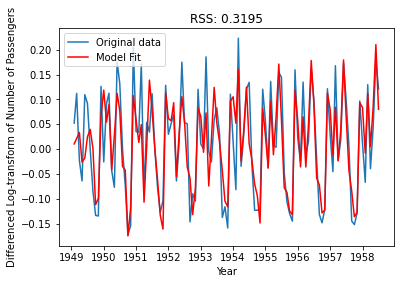

In [17]:
warnings.filterwarnings('ignore')

model = ARIMA(train, order=(8,0,8))
results_ARMA = model.fit()
plt.plot(train)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARMA.fittedvalues - train['#Passengers'])**2))
plt.legend(['Original data','Model Fit'])
print('Plotting ARIMA model,p=q=8')
plt.xlabel('Year')
plt.ylabel('Differenced Log-transform of Number of Passengers')

Now that we have fitted the model, let us do the forcast.

Plotting ARIMA model Forecast,p=q=8


Text(0, 0.5, 'Differenced Log-transform of Number of Passengers')

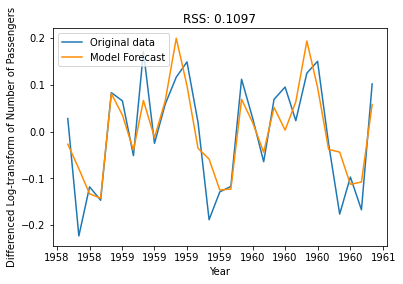

In [18]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
forecast=results_ARMA.forecast(steps=(np.shape(test)[0]))
plt.plot(test)
plt.plot(forecast, color='darkorange')
plt.title('RSS: %.4f'%np.sum((np.transpose((test.to_numpy()))[0] - forecast.to_numpy())**2))
plt.legend(['Original data','Model Forecast'])
print('Plotting ARIMA model Forecast,p=q=8')
plt.xlabel('Year')
plt.ylabel('Differenced Log-transform of Number of Passengers')

Let us look at in-sample and out-of-sample at the same time, without the log and differencing transform. Notice that we used cumsum (cumulative sum) to integrate differenced series and then we take exp to recover the series before any transformation. 

Text(0, 0.5, 'Number of Passengers')

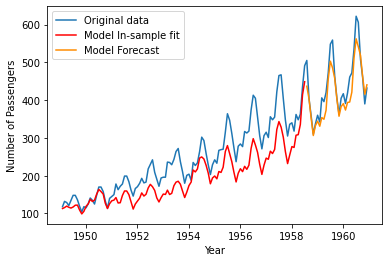

In [19]:
x0 = df_log["#Passengers"][0]

original = np.exp(df_logdff.cumsum() + x0)
fittedpart = np.exp(results_ARMA.fittedvalues.cumsum() + x0)
forecastpart = np.exp(forecast.cumsum() + results_ARMA.fittedvalues.cumsum()[-1] + x0)

plt.plot(original)
plt.plot(fittedpart,color='red')
plt.plot(forecastpart,color='darkorange')
plt.legend(['Original data','Model In-sample fit','Model Forecast'])
plt.xlabel('Year')
plt.ylabel('Number of Passengers')